In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras

In [2]:
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Input
from keras.models import Model
from keras.utils import to_categorical
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

In [49]:
# Setting these as global variables so that they can be shuffled to ensure an even distribution- many times I wasn't getting all 24/720 labels in the validation set

images = np.load('75/images.npy')
images = images.astype('float32')

# Function that shuffles the images and labels into training, validation, and test sets
def initialize():
    global imgs, train_imgs, val_imgs, test_imgs, train_labels, val_labels, test_labels, distributed
    indices = np.random.permutation(images.shape[0])
    imgs = images[indices]
    labels = np.load('75/labels.npy')
    labels = labels.astype('int32')
    labels = labels[indices]

    split_1 = int(18000*0.7)
    split_2 = int(18000*0.9)

    train_imgs = imgs[:split_1]
    train_labels = labels[:split_1]
    
    val_imgs = imgs[split_1:split_2]
    val_labels = labels[split_1:split_2]
    
    test_imgs = imgs[split_2:]
    test_labels = labels[split_2:]

    # Normalizing the images
    train_imgs = train_imgs / 255.0
    test_imgs = test_imgs / 255.0
    val_imgs = val_imgs / 255.0


    train_imgs = train_imgs.reshape((train_imgs.shape[0], 75, 75, 1))
    val_imgs = val_imgs.reshape((val_imgs.shape[0], 75, 75, 1))
    test_imgs = test_imgs.reshape((test_imgs.shape[0], 75, 75, 1))

    # print(train_imgs.shape, val_imgs.shape, test_imgs.shape)

## Classification Model

In [50]:
# Convert the time into 24 separate labels
def conv_time_24(time):
    ntime = 0
    if time[1] > 30:
        ntime = (time[0] + 0.5)
    else:
        ntime = time[0]
    return ntime

# Convert the time into 720 separate labels 
def conv_time_720(time):
    return time[0]*60 + time[1]

conv_time = conv_time_720
while True:
    initialize()
    train_labels_converted = np.array([conv_time(time) for time in train_labels])
    test_labels_converted = np.array([conv_time(time) for time in test_labels])
    val_labels_converted = np.array([conv_time(time) for time in val_labels])

    encoder = LabelEncoder()
    test_labels_encoded = encoder.fit_transform(test_labels_converted.reshape(-1))
    train_labels_encoded = encoder.fit_transform(train_labels_converted.reshape(-1))
    # print(train_labels_encoded)
    val_labels_encoded = encoder.fit_transform(val_labels_converted.reshape(-1))

    OHencoder = OneHotEncoder(sparse_output=False)
    train_labels_oh = OHencoder.fit_transform(train_labels_encoded.reshape(-1, 1))
    val_labels_oh = OHencoder.fit_transform(val_labels_encoded.reshape(-1, 1))
    
    # Check if all labels are present in the validation set, if not, reshuffle
    try:
        val_labels_oh = val_labels_oh.reshape((val_labels_oh.shape[0], 720))
        break
    except:
        pass

In [23]:
import tensorflow.keras.backend as K

#Common sense error function- checks the smaller of the differences by converting to military time
def common_sense_error(true, pred):
    diff1 = K.abs(pred-true)
    diff2 = K.abs(pred+12-true)
    return K.minimum(diff1, diff2)

In [63]:
input_shape = (75, 75, 1)

model = keras.models.Sequential()
model.add(keras.layers.Conv2D(kernel_size=(5,5), strides = (2,2), activation="relu", filters=32))
model.add(keras.layers.Conv2D(activation="relu", filters=32, kernel_size=(3,3), input_shape=input_shape))
model.add(keras.layers.MaxPooling2D(pool_size=2))
model.add(keras.layers.Conv2D(kernel_size=(3,3), activation="relu", filters=32))
model.add(keras.layers.Conv2D(kernel_size=(3,3), activation="relu", filters=32))
model.add(keras.layers.MaxPooling2D(pool_size=2))
model.add(keras.layers.Conv2D(kernel_size=(3,3), activation="relu", filters=64))
model.add(keras.layers.Conv2D(kernel_size=(3,3), activation="relu", filters=64))

model.add(keras.layers.Flatten())

model.add(keras.layers.Dense(units=512, activation="relu"))
model.add(keras.layers.Dense(units=512, activation="relu"))
# model.add(keras_cv.layers.DropBlock2D(block_size=5, rate=0.1))
model.add(keras.layers.Dense(units=256, activation="relu"))
model.add(keras.layers.Dense(units=256, activation="relu"))
# model.add(keras.layers.DropBlock2D(block_size=5, rate=0.1))
model.add(keras.layers.Dense(units=128, activation="sigmoid"))
model.add(keras.layers.Dense(units=64, activation="sigmoid"))
model.add(keras.layers.Dense(units=32, activation="sigmoid"))
# Output layer - one neuron for each class label
model.add(keras.layers.Dense(units=720, activation="softmax"))

optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss=common_sense_error, metrics=['accuracy'])

In [64]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

classification_history = model.fit(train_imgs, train_labels_oh, epochs=10, batch_size=256, validation_data=(val_imgs, val_labels_oh), callbacks=[early_stop])

Epoch 1/10
23/50 [============>.................] - ETA: 3s - loss: 0.0028 - accuracy: 0.0017

KeyboardInterrupt: 

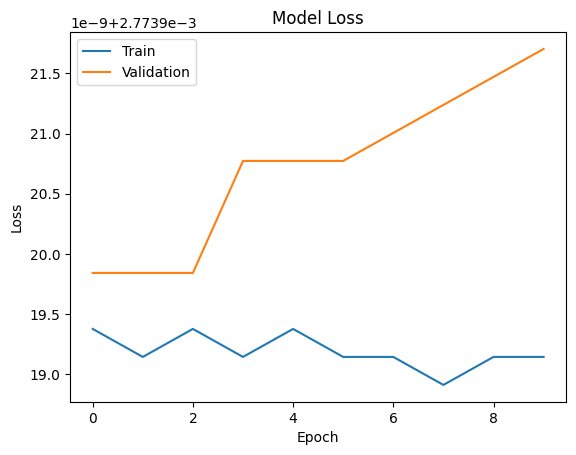

In [57]:
# Graph the model training
plt.plot(classification_history.history['loss'])
plt.plot(classification_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

In [58]:
# Measuring accuracy- picking the highest confidence label and comparing it to the true label
preds = model.predict(test_imgs)
preds = np.argmax(preds, axis=1)
print(preds)


# results = encoder.inverse_transform(preds)
# print(" ".join([str(i) for i in results]))

# common_sense_error = np.sum([common_sense_error(test_labels_converted[i], results[i]) for i in range(len(results))]) / len(results)
# print(common_sense_error)

accuracy = np.sum(results == test_labels_converted) / len(test_labels_converted)
print(accuracy*100, '%')

57/57 [==============================] - 0s 6ms/step
[476 476 476 ... 476 476 476]
0.1111111111111111 %


## Regression Model

In [10]:
import tensorflow.keras.backend as K

#returning the common sense difference between two times
def common_sense_error(true, pred):
    true = K.cast(true, 'float32')
    diff_1 = K.abs(true - pred)
    diff_2 = K.abs(true - (pred + 12))

    return K.minimum(diff_1, diff_2)

In [12]:
initialize()

# Convert the time into a continuous value
def conv_time(time):
    return round(time[0] + time[1]/60, 3)

train_labels_reg = np.array([conv_time(time) for time in train_labels])
test_labels_reg = np.array([conv_time(time) for time in test_labels])
val_labels_reg = np.array([conv_time(time) for time in val_labels])

model = keras.models.Sequential()
model.add(keras.layers.Conv2D(activation='relu', filters=32, kernel_size=(3,3), input_shape=(75, 75, 1)))
model.add(keras.layers.MaxPooling2D(pool_size=2))
model.add(keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
model.add(keras.layers.Conv2D(filters=32 ,kernel_size=(3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=2))
model.add(keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model.add(keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'))


model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(units=256, activation='relu'))
model.add(keras.layers.Dense(units=256, activation='relu'))
model.add(keras.layers.Dense(units=256, activation='relu'))
model.add(keras.layers.Dense(units=256, activation='relu'))
model.add(keras.layers.Dropout(0.1))
model.add(keras.layers.Dense(units=128, activation='relu'))
model.add(keras.layers.Dense(units=64, activation='relu'))
model.add(keras.layers.Dense(units=1, activation="softplus"))
model.compile(loss="mse", optimizer="adam", metrics=[common_sense_error])

early_stop = keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 10)

regression_model = model.fit(train_imgs, train_labels_reg, epochs=10, batch_size = 512, validation_data = (val_imgs, val_labels_reg), callbacks = [early_stop])

(14400, 75, 75, 1) (1800, 75, 75, 1) (1800, 75, 75, 1)
Epoch 1/10
29/29 [==============================] - 18s 571ms/step - loss: 17.4481 - common_sense_error: 3.0886 - val_loss: 12.2079 - val_common_sense_error: 3.0306
Epoch 2/10
29/29 [==============================] - 16s 570ms/step - loss: 12.2850 - common_sense_error: 3.0033 - val_loss: 12.3394 - val_common_sense_error: 3.0424
Epoch 3/10
 5/29 [====>.........................] - ETA: 15s - loss: 12.0630 - common_sense_error: 2.9919

KeyboardInterrupt: 

In [ ]:
# Measuring accuracy within 1 minute of the true time
reg_preds = model.predict(test_imgs)
accuracy = np.mean(abs(reg_preds - test_labels_reg) < 0.16)
print(accuracy*100, '%')

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
2.480956790123457 %


## Two-Headed Model

In [ ]:
initialize()

train_hours = train_labels[:, 0]
train_minutes = train_labels[:, 1]

val_hours = val_labels[:, 0]
val_minutes = val_labels[:, 1]

test_hours = test_labels[:, 0]
test_minutes = test_labels[:, 1]

train_minutes = train_minutes / 60
test_minutes = test_minutes / 60
val_minutes = val_minutes / 60

In [ ]:
import tensorflow.keras.backend as K

def common_sense_hour(true, pred):
    true = K.cast(true, 'float32')
    diff1 = K.abs(pred-true)
    diff2 = K.abs(pred+12-true)
    return K.minimum(diff1, diff2)

def common_sense_minute(true, pred):
    true = K.cast(true, 'float32')
    diff1 = K.abs(pred-true)
    diff2 = K.abs(pred+60-true)
    return K.minimum(diff1, diff2)

In [ ]:
inp = keras.layers.Input(shape = (75,75,1))
model = keras.layers.Convolution2D(32,kernel_size = (5,5), strides= (2,2), activation = "relu")(inp)
model = keras.layers.MaxPooling2D(pool_size =2)(model)
model = keras.layers.Convolution2D(32,kernel_size = (3,3),activation = "relu")(model)
model = keras.layers.Convolution2D(32,kernel_size = (3,3),activation = "relu")(model)
model = keras.layers.MaxPooling2D(pool_size =2)(model)
model = keras.layers.Convolution2D(64,kernel_size = (3,3),activation = "relu")(model)
model = keras.layers.Convolution2D(64,kernel_size = (1,1),activation = "relu")(model)
model = keras.layers.Flatten()(model)

d = keras.layers.Dense(256,activation = "relu")(model)
d = keras.layers.Dense(256,activation = "relu")(d)
d = keras.layers.Dropout(0.1)(d)
d = keras.layers.Dense(256,activation = "relu")(d)

# The hour head predicts confidence amonst 12 label classes- one for each hour 
hour = keras.layers.Dense(256,activation = "relu")(d)
hour = keras.layers.Dense(128,activation = "relu")(hour)
hour = keras.layers.Dense(64,activation = "relu")(hour)
hour = keras.layers.Dense(32,activation = "relu")(hour)
hour = keras.layers.Dense(16,activation = "relu")(hour)
hour = keras.layers.Dense(12,activation= "softmax", name= "hour")(hour)

# The minute head runs a regression on a continuous value
minute = keras.layers.Dense(256,activation = "relu")(d)
minute = keras.layers.Dense(256,activation = "relu")(minute)
minute = keras.layers.Dense(256,activation = "relu")(minute)
minute = keras.layers.Dense(128,activation = "relu")(minute)
minute = keras.layers.Dense(64,activation = "relu")(minute)
minute = keras.layers.Dense(32,activation = "relu")(minute)
minute = keras.layers.Dense(16,activation = "relu")(minute)
minute = keras.layers.Dense(1, activation = "softplus", name = "minute")(minute)

model = tf.keras.models.Model(inputs=inp, outputs=[hour, minute])
optim = tf.keras.optimizers.Adam()
model.compile(loss=['sparse_categorical_crossentropy', 'mse'], optimizer=optim, metrics=['accuracy',"mae"])

early_stop = keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 10)

model.fit(train_imgs, [train_hours, train_minutes], epochs=30, batch_size = 512, validation_data = (val_imgs, [val_hours, val_minutes]), callbacks = [early_stop])

Epoch 1/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - hour_accuracy: 0.0877 - hour_loss: 2.4857 - loss: 2.5919 - minute_loss: 0.1062 - minute_mae: 0.2738 - val_hour_accuracy: 0.0781 - val_hour_loss: 2.4853 - val_loss: 2.5691 - val_minute_loss: 0.0831 - val_minute_mae: 0.2513
Epoch 2/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - hour_accuracy: 0.0821 - hour_loss: 2.4849 - loss: 2.5689 - minute_loss: 0.0840 - minute_mae: 0.2512 - val_hour_accuracy: 0.0800 - val_hour_loss: 2.4854 - val_loss: 2.5690 - val_minute_loss: 0.0829 - val_minute_mae: 0.2513
Epoch 3/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - hour_accuracy: 0.0903 - hour_loss: 2.4848 - loss: 2.5692 - minute_loss: 0.0844 - minute_mae: 0.2511 - val_hour_accuracy: 0.0794 - val_hour_loss: 2.4859 - val_loss: 2.5700 - val_minute_loss: 0.0844 - val_minute_mae: 0.2519
Epoch 4/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - hour_accuracy: 0.0829 - hour_loss: 2.4849 - loss: 2.5684 - minute_loss: 0.0835 - minute_mae: 0.2496 - val_hour_accuracy: 0

In [ ]:
predictions = model.predict(test_imgs)
hour_p = np.argmax(predictions[0], axis = 1)
minutes_p = predictions[1]

accuracy = np.mean(np.abs(hour_p - test_hours) < 1) * np.mean(np.abs(minutes_p - test_minutes) < 5)
print(accuracy*100, '%')

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
7.222222222222221 %
